In [868]:
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np

import utils

In [869]:
%matplotlib inline

In [870]:
main_path = Path.cwd() / ".."

---

Cargamos las imgnes a usar en el ejercicio.

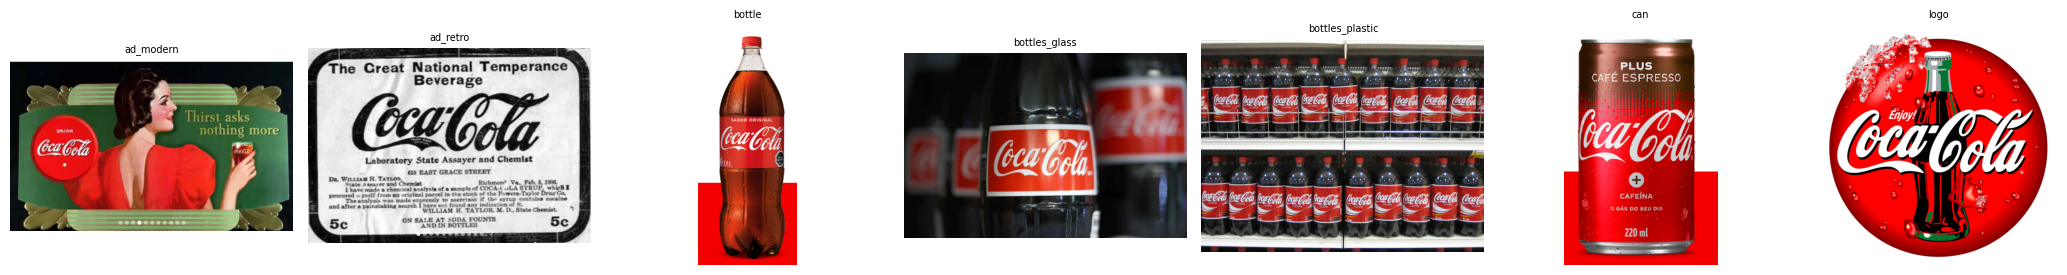

imgs shape:

ad_modern:        h_429, w_715
ad_retro:         h_493, w_715
bottle:           h_500, w_207
bottles_glass:    h_450, w_687
bottles_plastic:  h_598, w_799
can:              h_363, w_233
logo:             h_1389, w_1389


In [871]:
folder_path = main_path / "data/images"

dict_imgs = {}
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    name, _ = os.path.splitext(filename)
    dict_imgs[name] = cv2.imread(file_path)

utils.plot_imgs(list(dict_imgs.values()), list(dict_imgs.keys()), rows=1, figsize=3)

print("imgs shape:\n")
for name, img in dict_imgs.items():
    blank = " "
    print(f"{name}:{blank*(16-len(name))} h_{img.shape[0]}, w_{img.shape[1]}")

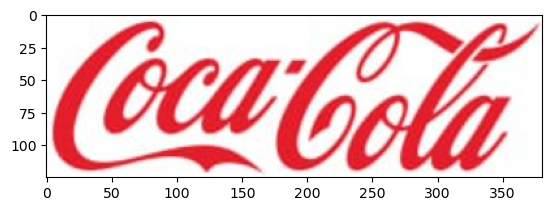

In [872]:
folder_path = main_path / "data/template"
filename = "logo_template.png"
file_path = os.path.join(folder_path, filename)

template = cv2.imread(file_path)

# Crop the template
template = template[27:152,7:388,:]
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))

---

##### Ejercicio 1
Obtener una detección del logo en cada imgn sin falsos positivos.

Como podemos observar, los logos en las imgnes sobre las que vamos a buscar están en blanco sobre rojo o negro sobre blanco. Por lo cual un template con el logo en tono medio (rojo) sobre fondo blanco va a ser subóptimo para matchear.

Vamos a obtener los bordes de las imágenes y del template utilizando Canny. De esta manera vamos a poder matchear generalizando a nuevos casos en los que el logo aparezca sobre un fondo completamente diferente.

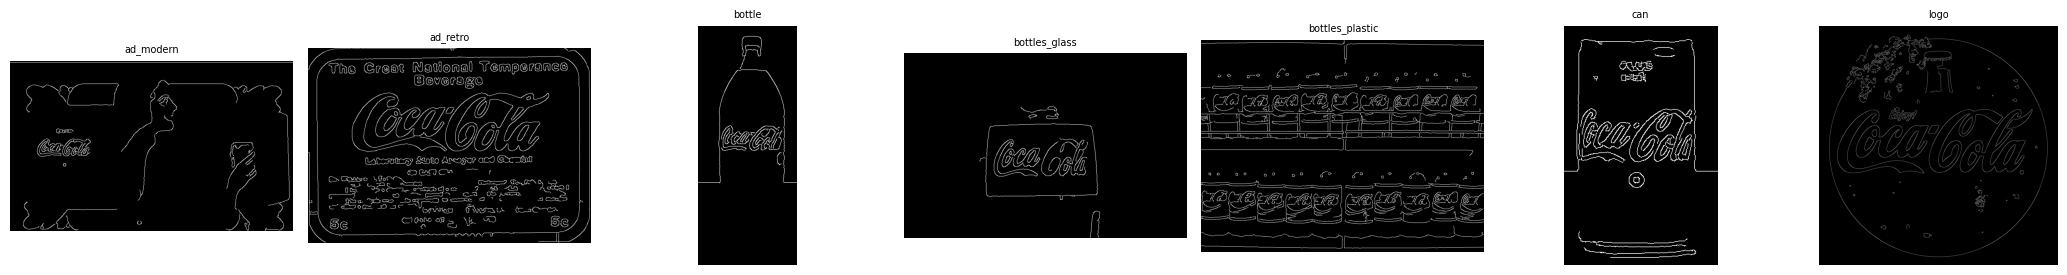

In [873]:
dict_imgs_border = {}
for name, img in dict_imgs.items():
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, ksize=(7, 7), sigmaX=3, sigmaY=3)
    # Obtain borders using Canny
    img_border = cv2.Canny(img_gray, threshold1=5, threshold2=200)

    dict_imgs_border[name] = img_border

utils.plot_imgs(list(dict_imgs_border.values()), list(dict_imgs_border.keys()), rows=1, figsize=3)

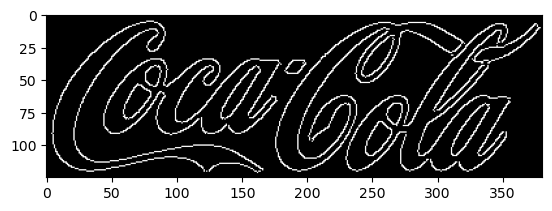

In [874]:
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
# Gaussian blur to remove noise
template_gray = cv2.GaussianBlur(template_gray, ksize=(5, 5), sigmaX=3, sigmaY=3)
# Obtain borders using Canny
template_border = cv2.Canny(template_gray, threshold1=5, threshold2=200)

plt.imshow(cv2.cvtColor(template_border, cv2.COLOR_BGR2RGB))

Encontramos además logos de diversos tamaños y proporciones (debido a la curvatura de los envases por ej.) en las imágenes sobre las que vamos a matchear. Por este motivo vamos a tener que generar múltiples templates variando la escala y la proporción para poder matchearlos.

logo menor: h_35, w_75
ratio logo-imgn: 0.094


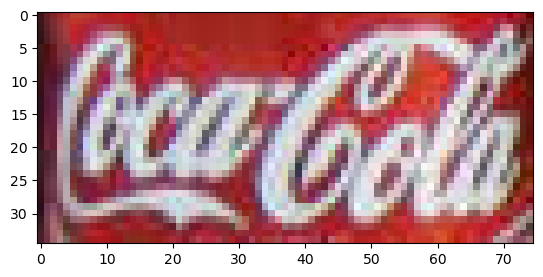

In [875]:
# Logo de menor encontrado en las imágenes
logo_menor = dict_imgs["bottles_plastic"][154:189,115:190,:]

plt.imshow(cv2.cvtColor(logo_menor, cv2.COLOR_BGR2RGB))

print(f"logo menor: h_{logo_menor.shape[0]}, w_{logo_menor.shape[1]}")

ratio_menor_img = round(logo_menor.shape[1] / dict_imgs["bottles_plastic"].shape[1], 3)
print(f"ratio logo-imgn: {ratio_menor_img}")

logo mayor: h_400, w_1155
ratio logo-imgn: 0.832


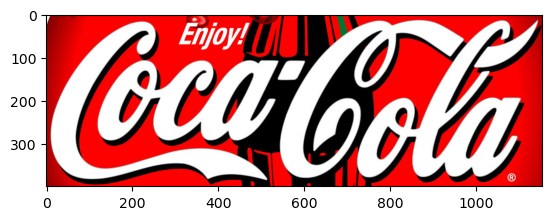

In [876]:
# Logo de mayor tamaño encontrado en las imágenes
logo_mayor = dict_imgs["logo"][470:870,95:1250,:]

plt.imshow(cv2.cvtColor(logo_mayor, cv2.COLOR_BGR2RGB))

print(f"logo mayor: h_{logo_mayor.shape[0]}, w_{logo_mayor.shape[1]}")

ratio_mayor_img = round(logo_mayor.shape[1] / dict_imgs["logo"].shape[1], 3)
print(f"ratio logo-imgn: {ratio_mayor_img}")

In [877]:
def _get_scaled_templates(template, img, min_ratio, max_ratio, n_scales=20, scales_x=[1]):
    # Define size of different templates based on the size of the img.
    ratio_template_img = template.shape[1] / max(img.shape[0], img.shape[1])

    min_scale = (min_ratio * 1.6) / ratio_template_img
    max_scale = max_ratio / ratio_template_img

    # Exponential scale to match preciselly small logos.
    scales = np.exp(
        np.linspace(
            np.log(min_scale), np.log(max_scale), n_scales
        )
    )

    list_templates = []
    for scale in scales:
        for scale_x in scales_x:
            list_templates.append(
                cv2.resize(template, None, fx=scale * scale_x, fy=scale)
            )

    return list_templates
    

---

In [878]:
def single_match(template, img, method, n_scales=20, scales_x=[0.7, 0.85, 1]):
    method = eval(method)

    list_templates = _get_scaled_templates(
        template=template,
        img=img,
        min_ratio=ratio_menor_img,
        max_ratio=ratio_mayor_img,
        n_scales=n_scales,
        scales_x=scales_x,
    )

    list_val = []
    list_bbox = []
    for template in list_templates:
        template_too_tall = template.shape[0] > img.shape[0]
        template_too_wide = template.shape[1] > img.shape[1]
        if template_too_tall | template_too_wide:
            continue

        match = cv2.matchTemplate(img, template, method)

        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(match)
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
            val = min_val
        else:
            top_left = max_loc
            val = max_val
        bottom_right = (top_left[0] + template.shape[1], top_left[1] + template.shape[0])
        match_bbox = [top_left, bottom_right]

        # Avg value per pixel to compare templates of different sizes
        if method not in [
            cv2.TM_CCOEFF_NORMED,
            cv2.TM_CCORR_NORMED,
            cv2.TM_SQDIFF_NORMED,
        ]:
            val = val / len(template.flatten())

        # KEY STEP: postprocess weighting scores to prioritize matches with bigger templates
        # exponent = 0 equals no postprocessing. Good results for 0.5 < exponent <= 0.7.
        val = val * template.shape[0] ** (0.6)

        list_val.append(val)
        list_bbox.append(match_bbox)

    _, bbox = max([(val, bbox) for val, bbox in zip(list_val, list_bbox)])

    return bbox

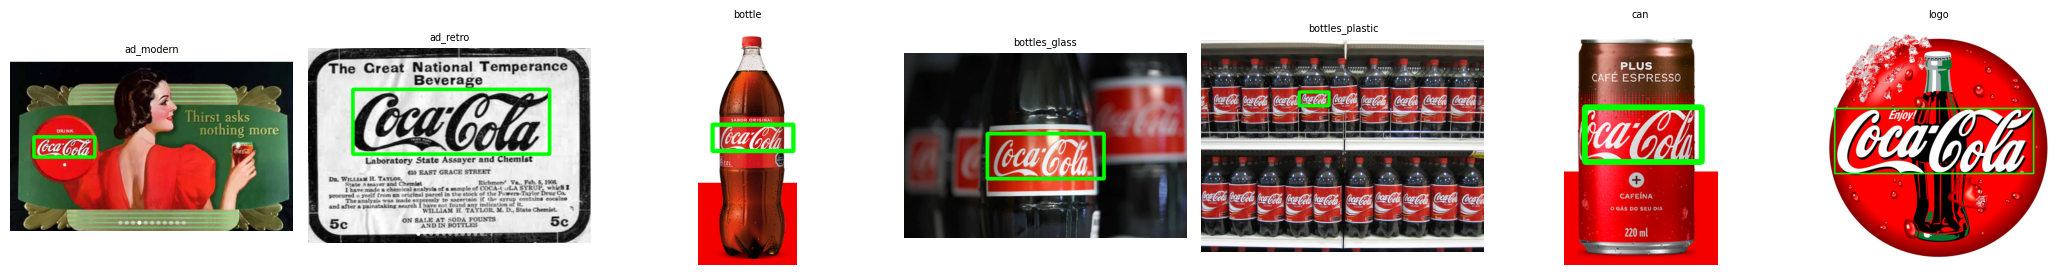

In [879]:
method = "cv2.TM_CCOEFF"

list_annotated = []
for img_name in dict_imgs_border.keys():
    bbox = single_match(
        template=template_border, img=dict_imgs_border[img_name], method=method
    )

    img_annotated = dict_imgs[img_name].copy()
    thickness = int(max(img.shape) / 180)
    cv2.rectangle(img_annotated, bbox[0], bbox[1], color=(0, 255, 0), thickness=thickness)

    list_annotated.append(img_annotated)

utils.plot_imgs(list_annotated, list(dict_imgs_border.keys()), rows=1, figsize=3)